In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from steams.data import KVyQVx
from steams.models.transformer import EncoderTransformer2
from steams.trainer import AttentionTrainer,train, evaluation, prediction_prime, ensemble_prime
from steams.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 2
    pin_memory = True
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [10]:
#model
model = EncoderTransformer2(input_k=2,input_q=2, input_v=1, hidden_size=32,dim_feedforward=10,num_blk=2,dropout=0.1)

In [11]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# AttentionTrainer object
obj = AttentionTrainer(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [13]:
# training
train(obj,train_dataset,valid_dataset,niter=200,n_iter_stop=32,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  0.639452  0.491845
  epoch     train    valid
0     1  0.570047  0.43665
  epoch     train     valid
0     2  0.509273  0.379999
  epoch     train     valid
0     3  0.453942  0.328287
  epoch     train     valid
0     4  0.433264  0.306501
  epoch     train     valid
0     5  0.413842  0.287681
  epoch     train     valid
0     6  0.393843  0.274931
  epoch     train     valid
0     7  0.387666  0.274024
  epoch     train     valid
0     8  0.370046  0.265016
  epoch     train     valid
0     9  0.355777  0.264859
  epoch     train     valid
0    10  0.354412  0.242836
  epoch    train     valid
0    11  0.33657  0.237308
  epoch     train     valid
0    12  0.321515  0.241783
  epoch     train     valid
0    13  0.313918  0.231179
  epoch     train     valid
0    14  0.301939  0.225067
  epoch     train     valid
0    15  0.307906  0.209748
  epoch     train     valid
0    16  0.295598  0.219628
  epoch     train     valid
0    17  0.288119  0.202

In [14]:
enc_attention_weights = torch.cat(model.attention_weights, 0)

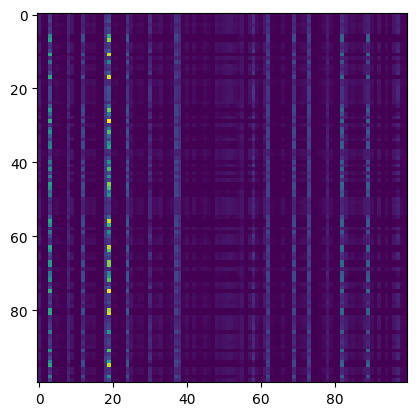

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(enc_attention_weights[1])

In [17]:
obj.save_model(resdir,"1d-trasnf_enc")

## Evaluation

In [18]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [19]:
criterion = R2()
#criterion = torch.nn.MSELoss()
obj.init_criterion(criterion)

In [20]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.8789339996874332


In [21]:
criterion = RMSE()
obj.init_criterion(criterion)

In [22]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.1814138749614358


In [23]:
criterion = variance()
obj.init_criterion(criterion)

In [24]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.018446459143888205


## QQplot

In [25]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [26]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


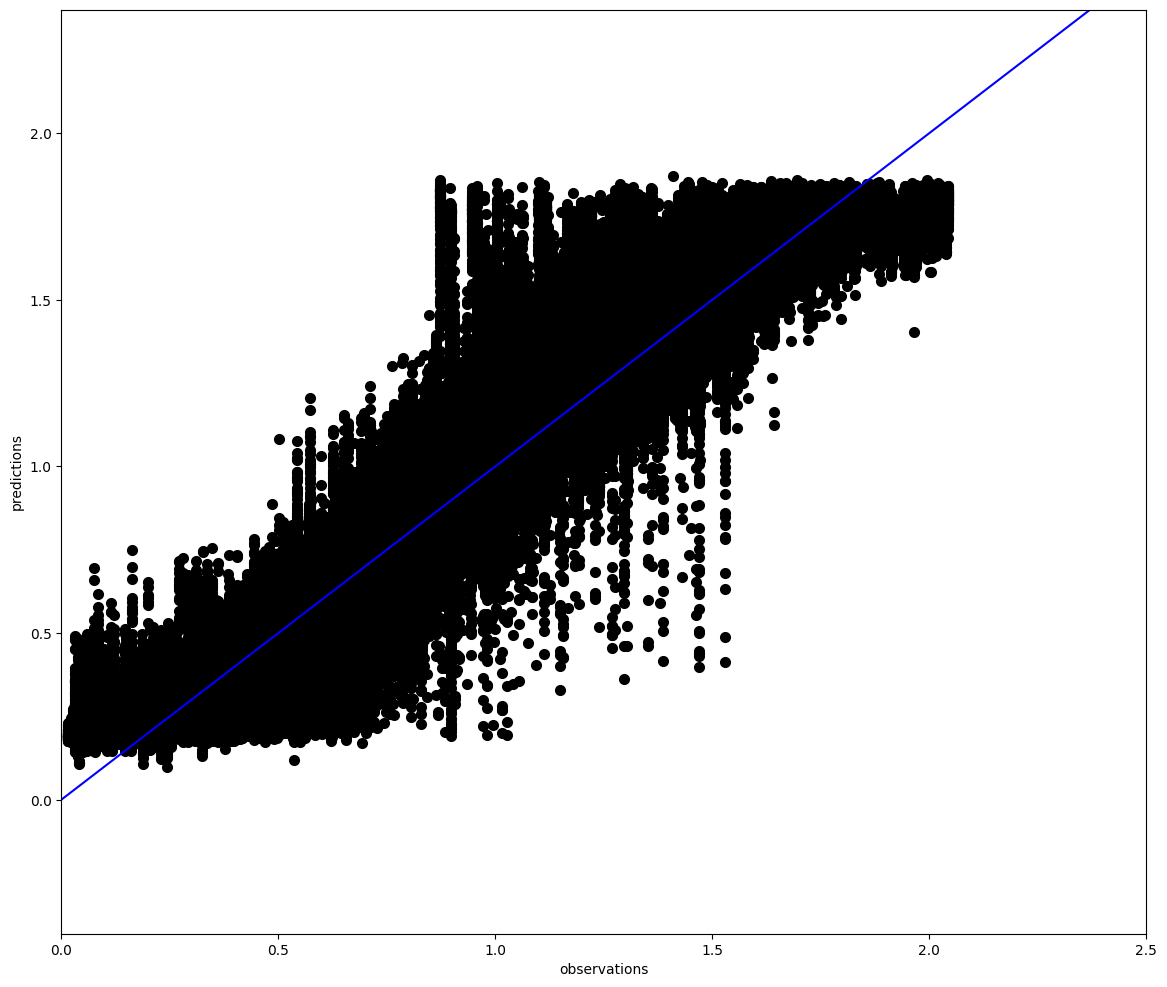

In [27]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1d-qqplot.png')
plt.savefig(fig_filename, dpi = 300)